<a href="https://colab.research.google.com/github/evan-randall/DS-Unit-2-Kaggle-Challenge/blob/master/module3-cross-validation/Copy_of_LS_DS_223_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 2, Module 3*

---

# Cross-Validation


## Assignment
- [ ] [Review requirements for your portfolio project](https://lambdaschool.github.io/ds/unit2), then submit your dataset.
- [ ] Continue to participate in our Kaggle challenge. 
- [ ] Use scikit-learn for hyperparameter optimization with RandomizedSearchCV.
- [ ] Submit your predictions to our Kaggle competition. (Go to our Kaggle InClass competition webpage. Use the blue **Submit Predictions** button to upload your CSV file. Or you can use the Kaggle API to submit your predictions.)
- [ ] Commit your notebook to your fork of the GitHub repo.


**You can't just copy** from the lesson notebook to this assignment.

- Because the lesson was **regression**, but the assignment is **classification.**
- Because the lesson used [TargetEncoder](https://contrib.scikit-learn.org/categorical-encoding/targetencoder.html), which doesn't work as-is for _multi-class_ classification.

So you will have to adapt the example, which is good real-world practice.

1. Use a model for classification, such as [RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)
2. Use hyperparameters that match the classifier, such as `randomforestclassifier__ ...`
3. Use a metric for classification, such as [`scoring='accuracy'`](https://scikit-learn.org/stable/modules/model_evaluation.html#common-cases-predefined-values)
4. If you’re doing a multi-class classification problem — such as whether a waterpump is functional, functional needs repair, or nonfunctional — then use a categorical encoding that works for multi-class classification, such as [OrdinalEncoder](https://contrib.scikit-learn.org/categorical-encoding/ordinal.html) (not [TargetEncoder](https://contrib.scikit-learn.org/categorical-encoding/targetencoder.html))



## Stretch Goals

### Reading
- Jake VanderPlas, [Python Data Science Handbook, Chapter 5.3](https://jakevdp.github.io/PythonDataScienceHandbook/05.03-hyperparameters-and-model-validation.html), Hyperparameters and Model Validation
- Jake VanderPlas, [Statistics for Hackers](https://speakerdeck.com/jakevdp/statistics-for-hackers?slide=107)
- Ron Zacharski, [A Programmer's Guide to Data Mining, Chapter 5](http://guidetodatamining.com/chapter5/), 10-fold cross validation
- Sebastian Raschka, [A Basic Pipeline and Grid Search Setup](https://github.com/rasbt/python-machine-learning-book/blob/master/code/bonus/svm_iris_pipeline_and_gridsearch.ipynb)
- Peter Worcester, [A Comparison of Grid Search and Randomized Search Using Scikit Learn](https://blog.usejournal.com/a-comparison-of-grid-search-and-randomized-search-using-scikit-learn-29823179bc85)

### Doing
- Add your own stretch goals!
- Try other [categorical encodings](https://contrib.scikit-learn.org/categorical-encoding/). See the previous assignment notebook for details.
- In additon to `RandomizedSearchCV`, scikit-learn has [`GridSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html). Another library called scikit-optimize has [`BayesSearchCV`](https://scikit-optimize.github.io/notebooks/sklearn-gridsearchcv-replacement.html). Experiment with these alternatives.
- _[Introduction to Machine Learning with Python](http://shop.oreilly.com/product/0636920030515.do)_ discusses options for "Grid-Searching Which Model To Use" in Chapter 6:

> You can even go further in combining GridSearchCV and Pipeline: it is also possible to search over the actual steps being performed in the pipeline (say whether to use StandardScaler or MinMaxScaler). This leads to an even bigger search space and should be considered carefully. Trying all possible solutions is usually not a viable machine learning strategy. However, here is an example comparing a RandomForestClassifier and an SVC ...

The example is shown in [the accompanying notebook](https://github.com/amueller/introduction_to_ml_with_python/blob/master/06-algorithm-chains-and-pipelines.ipynb), code cells 35-37. Could you apply this concept to your own pipelines?


### BONUS: Stacking!

Here's some code you can use to "stack" multiple submissions, which is another form of ensembling:

```python
import pandas as pd

# Filenames of your submissions you want to ensemble
files = ['submission-01.csv', 'submission-02.csv', 'submission-03.csv']

target = 'status_group'
submissions = (pd.read_csv(file)[[target]] for file in files)
ensemble = pd.concat(submissions, axis='columns')
majority_vote = ensemble.mode(axis='columns')[0]

sample_submission = pd.read_csv('sample_submission.csv')
submission = sample_submission.copy()
submission[target] = majority_vote
submission.to_csv('my-ultimate-ensemble-submission.csv', index=False)
```

In [0]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [0]:
import pandas as pd

# Merge train_features.csv & train_labels.csv
train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))

# Read test_features.csv & sample_submission.csv
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

In [34]:
train.shape, test.shape

((59400, 41), (14358, 40))

In [0]:
# Defining a function to wrangle train, validate, and test sets 
import numpy as np

def wrangle(X):
    
    # Prevent SettingWithCopyWarning
    X = X.copy()
    
    # Setting latitude values near zero equal to zero
    X['latitude'] = X['latitude'].replace(-2e-08, 0)
    
    # replace zeros with nulls
    cols_with_zeros = ['longitude', 'latitude','district_code','amount_tsh',
                       'population','construction_year','num_private']
    for col in cols_with_zeros:
        X[col] = X[col].replace(0, np.nan)
            
    # Drop duplicate columns
    duplicates = ['quantity_group', 'payment_type', 'waterpoint_type_group',
                  'extraction_type_group','extraction_type_class','source_type']
    X = X.drop(columns=duplicates)
    
    # Drop unusable columns
    unusable_variance = ['recorded_by', 'id']
    X = X.drop(columns=unusable_variance)
    
    # Convert date_recorded to datetime
    X['date_recorded'] = pd.to_datetime(X['date_recorded'], infer_datetime_format=True)
    
    # Extract components from date_recorded, then drop the original column
    # This will give us just the year for the next feature
    X['year_recorded'] = X['date_recorded'].dt.year
    X['month_recorded'] = X['date_recorded'].dt.month
    X['day_recorded'] = X['date_recorded'].dt.day
    X = X.drop(columns='date_recorded')
     
    # creating columns 'years' and 'years_MISSING' 
    # to represent years from construction_year to date_recorded
    X['years'] = X['year_recorded'] - X['construction_year']
    X['years_MISSING'] = X['years'].isnull()
    
    # return the wrangled dataframe
    return X

train = wrangle(train)
test = wrangle(test)

In [36]:
# setting target
target = 'status_group'

# train features, dropping target
train_features = train.drop(columns=[target])

# list of the numeric features
numeric_features = train_features.select_dtypes(include='number').columns.tolist()

# series with the cardinality of the nonnumeric features
cardinality = train_features.select_dtypes(exclude='number').nunique()

# list of all categorical features with cardinality <= 50
categorical_features = cardinality[cardinality <= 50].index.tolist()

# Combine the lists 
features = numeric_features + categorical_features

print(features)

['amount_tsh', 'gps_height', 'longitude', 'latitude', 'num_private', 'region_code', 'district_code', 'population', 'construction_year', 'year_recorded', 'month_recorded', 'day_recorded', 'years', 'basin', 'region', 'public_meeting', 'scheme_management', 'permit', 'extraction_type', 'management', 'management_group', 'payment', 'water_quality', 'quality_group', 'quantity', 'source', 'source_class', 'waterpoint_type', 'years_MISSING']


In [37]:
X_train = train[features]
y_train = train[target]
X_test = test

X_train.shape, y_train.shape, X_test.shape

((59400, 29), (59400,), (14358, 36))

In [0]:
# importing all libraries
import category_encoders as ce
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score

In [39]:
# Making pipeline, Ordinal Encoding with a RandomForestClassifier

target = 'status_group'
features = numeric_features + categorical_features

X_train = train[features]
y_train = train[target]


pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='mean'), 
    RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, max_depth=18) 
)

k = 10
scores = cross_val_score(pipeline, X_train, y_train, cv=k, 
                         scoring='accuracy')
print(f'Accuracy Scores for {k} folds:', scores)

Accuracy Scores for 10 folds: [0.81632997 0.81969697 0.81127946 0.803367   0.82037037 0.8037037
 0.81548822 0.8016835  0.8040404  0.81801347]


In [40]:
scores.mean()

0.8113973063973065

In [41]:
#Looking at hyperparameters 

print('Model Hyperparameters:')
print(pipeline.named_steps['randomforestclassifier'])

Model Hyperparameters:
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=18, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)


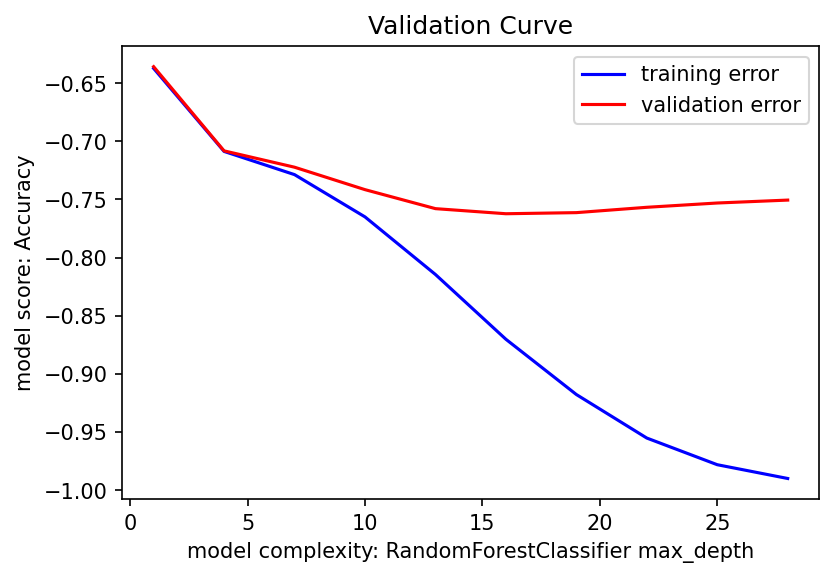

In [42]:
# plotting validation curve
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.model_selection import validation_curve
from sklearn.tree import DecisionTreeClassifier

pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(), 
    DecisionTreeClassifier()
)

depth = range(1, 30, 3)
train_scores, val_scores = validation_curve(
    pipeline, X_train, y_train,
    param_name='decisiontreeclassifier__max_depth', 
    param_range=depth, scoring='accuracy', 
    cv=3,
    n_jobs=-1
)

plt.figure(dpi=150)
plt.plot(depth, np.mean(-train_scores, axis=1), color='blue', label='training error')
plt.plot(depth, np.mean(-val_scores, axis=1), color='red', label='validation error')
plt.title('Validation Curve')
plt.xlabel('model complexity: RandomForestClassifier max_depth')
plt.ylabel('model score: Accuracy')
plt.legend();

In [0]:
# Using RandomizedSearchCV to find optimal values for hyperparameters
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import randint, uniform

features = numeric_features + categorical_features
X_train = train[features]
y_train = train[target]

# making pipeline for random search
pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(), 
    RandomForestClassifier(random_state=42)
)

# setting parameter distributions
param_distributions = {
    'simpleimputer__strategy': ['mean', 'median'], 
    'randomforestclassifier__n_estimators': randint(50, 500), 
    'randomforestclassifier__max_depth': [5, 10, 15, 20, None], 
    'randomforestclassifier__max_features': uniform(0, 1), 
}

# Using colab I will set n_iter = 10 and cv = 3 (for a quicker run)
search = RandomizedSearchCV(     
    pipeline, 
    param_distributions=param_distributions, 
    n_iter=10, 
    cv=3, 
    scoring='accuracy', 
    verbose=10, 
    return_train_score=True, 
    n_jobs=-1
)

search.fit(X_train, y_train);

[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  8.5min
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


In [0]:
print('Best hyperparameters', search.best_params_)
print('Accuracy', search.best_score_)

In [0]:
pd.DataFrame(search.cv_results_).sort_values(by='rank_test_score').T

In [0]:
X_test = test[features]
assert all(X_train.columns == X_test.columns)

In [0]:
y_pred = pipeline.predict(X_test)

In [0]:
submission = sample_submission.copy()
submission['status_group'] = y_pred
submission.to_csv('evansubmission3.csv', index=False)